In [225]:
import matplotlib.pyplot as plt
import mne
import numpy as np
from scipy.stats import ttest_rel
# from braindecode.datasets import MOABBDataset

from moabb.datasets import Nakanishi2015

In [226]:
# dataset = MOABBDataset(dataset_name="Nakanishi2015", subject_ids=[1])

<!-- fname = C:\Users\Sunsun\mne_data\MNE-nakanishi-data\mnakanishi\12JFPM_SSVEP\raw\master\data\s1.mat -->

In [227]:
dataset = Nakanishi2015()

subject =[7, 8, 9]

dataset.subject_list = subject

In [228]:
dataset

In [229]:
sessions = dataset.get_data(subjects=subject)

Trial data de-meaned and concatenated with a buffer to create continuous data
Trial data de-meaned and concatenated with a buffer to create continuous data
Trial data de-meaned and concatenated with a buffer to create continuous data


In [230]:
session_name = "session_0"
run_name = "run_0"
raw_list = [sessions[id][session_name][run_name] for id in sessions]

raw = mne.concatenate_raws(raw_list)

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.000 (s)


c:\Users\Sunsun\.virtualenvs\HybridSpeller-q8UBACmb\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


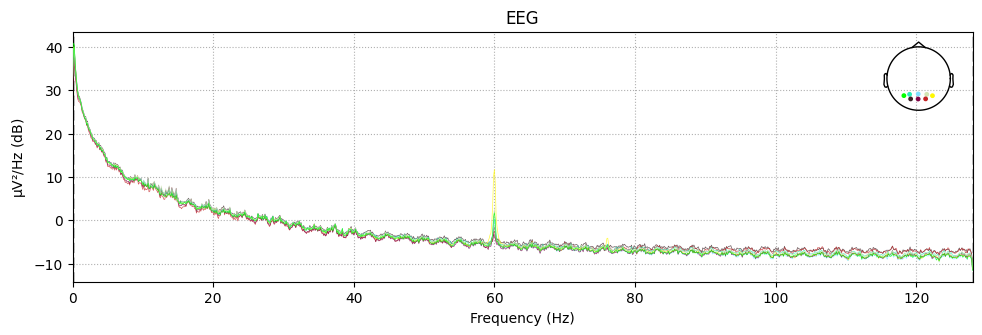

In [231]:
raw.plot_psd()

In [232]:
mne.find_events(raw)

540 events found
Event IDs: [ 1  2  3  4  5  6  7  8  9 10 11 12]


array([[    50,      0,      1],
       [  1264,      0,      1],
       [  2478,      0,      1],
       ...,
       [651968,      0,     12],
       [653182,      0,     12],
       [654396,      0,     12]], dtype=int64)

In [233]:
# Load raw data
# data_path = mne.datasets.ssvep.data_path()
# data_path = moabb.datasets.Nakanishi2015.data_path(subject = 1)

# bids_fname = (data_path)

# raw = mne.io.read_raw_brainvision(bids_fname, preload=True, verbose=False)
raw.info['line_freq'] = 60.

# Set montage
montage = mne.channels.make_standard_montage('standard_1005')
raw.set_montage(montage, verbose=False)

# Set common average reference
raw.set_eeg_reference('average', projection=False, verbose=False)

# Apply bandpass filter
raw.filter(l_freq=0.1, h_freq=None, fir_design='firwin', verbose=False)

# Construct epochs
event_id = {
    '9.2hz': 12
}
# events, _ = mne.events_from_annotations(raw, verbose=False)
events = mne.find_events(raw)
tmin, tmax = -1., 4.  # in s
baseline = None
epochs = mne.Epochs(
    raw, events=events,
    event_id=[event_id['9.2hz']], tmin=tmin,
    tmax=tmax, baseline=baseline, verbose=False)

540 events found
Event IDs: [ 1  2  3  4  5  6  7  8  9 10 11 12]


In [234]:
tmin = 1.
tmax = 4.
fmin = 1.
fmax = 90.
sfreq = epochs.info['sfreq']

spectrum = epochs.compute_psd(
    'welch',
    n_fft=int(sfreq * (tmax - tmin)),
    n_overlap=0, n_per_seg=None,
    tmin=tmin, tmax=tmax,
    fmin=fmin, fmax=fmax,
    window='boxcar',
    verbose=False)
psds, freqs = spectrum.get_data(return_freqs=True)

In [235]:
def snr_spectrum(psd, noise_n_neighbor_freqs=1, noise_skip_neighbor_freqs=1):
    """Compute SNR spectrum from PSD spectrum using convolution.

    Parameters
    ----------
    psd : ndarray, shape ([n_trials, n_channels,] n_frequency_bins)
        Data object containing PSD values. Works with arrays as produced by
        MNE's PSD functions or channel/trial subsets.
    noise_n_neighbor_freqs : int
        Number of neighboring frequencies used to compute noise level.
        increment by one to add one frequency bin ON BOTH SIDES
    noise_skip_neighbor_freqs : int
        set this >=1 if you want to exclude the immediately neighboring
        frequency bins in noise level calculation

    Returns
    -------
    snr : ndarray, shape ([n_trials, n_channels,] n_frequency_bins)
        Array containing SNR for all epochs, channels, frequency bins.
        NaN for frequencies on the edges, that do not have enough neighbors on
        one side to calculate SNR.
    """
    # Construct a kernel that calculates the mean of the neighboring
    # frequencies
    averaging_kernel = np.concatenate((
        np.ones(noise_n_neighbor_freqs),
        np.zeros(2 * noise_skip_neighbor_freqs + 1),
        np.ones(noise_n_neighbor_freqs)))
    averaging_kernel /= averaging_kernel.sum()

    # Calculate the mean of the neighboring frequencies by convolving with the
    # averaging kernel.
    mean_noise = np.apply_along_axis(
        lambda psd_: np.convolve(psd_, averaging_kernel, mode='valid'),
        axis=-1, arr=psd
    )

    # The mean is not defined on the edges so we will pad it with nas. The
    # padding needs to be done for the last dimension only so we set it to
    # (0, 0) for the other ones.
    edge_width = noise_n_neighbor_freqs + noise_skip_neighbor_freqs
    pad_width = [(0, 0)] * (mean_noise.ndim - 1) + [(edge_width, edge_width)]
    mean_noise = np.pad(
        mean_noise, pad_width=pad_width, constant_values=np.nan
    )

    return psd / mean_noise

In [236]:
snrs = snr_spectrum(psds, noise_n_neighbor_freqs=3,
                    noise_skip_neighbor_freqs=1)

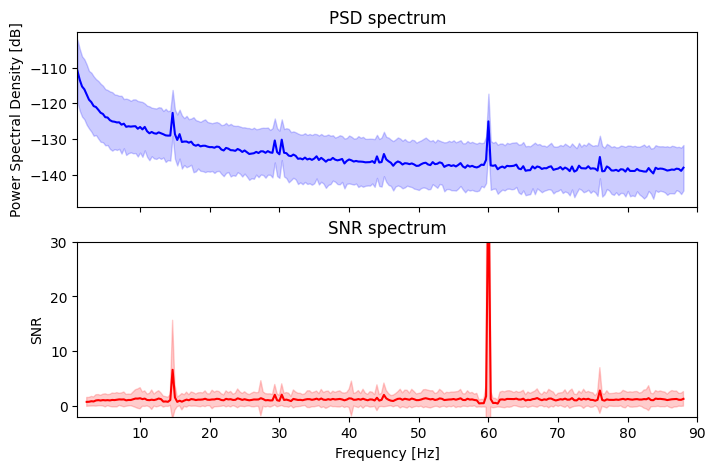

In [237]:
fig, axes = plt.subplots(2, 1, sharex='all', sharey='none', figsize=(8, 5))
freq_range = range(np.where(np.floor(freqs) == 1.)[0][0],
                   np.where(np.ceil(freqs) == fmax - 1)[0][0])

psds_plot = 10 * np.log10(psds)
psds_mean = psds_plot.mean(axis=(0, 1))[freq_range]
psds_std = psds_plot.std(axis=(0, 1))[freq_range]
axes[0].plot(freqs[freq_range], psds_mean, color='b')
axes[0].fill_between(
    freqs[freq_range], psds_mean - psds_std, psds_mean + psds_std,
    color='b', alpha=.2)
axes[0].set(title="PSD spectrum", ylabel='Power Spectral Density [dB]')

# SNR spectrum
snr_mean = snrs.mean(axis=(0, 1))[freq_range]
snr_std = snrs.std(axis=(0, 1))[freq_range]

axes[1].plot(freqs[freq_range], snr_mean, color='r')
axes[1].fill_between(
    freqs[freq_range], snr_mean - snr_std, snr_mean + snr_std,
    color='r', alpha=.2)
axes[1].set(
    title="SNR spectrum", xlabel='Frequency [Hz]',
    ylabel='SNR', ylim=[-2, 30], xlim=[fmin, fmax])
fig